<a href="https://colab.research.google.com/github/MohammadYehya/SegmentAnythingModel_SAM/blob/main/SAM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from transformers import Sam2Processor, Sam2Model, infer_device
import torch
from PIL import Image
from google.colab import files
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# Upload image (Colab) or load locally
uploaded = files.upload()
img_path = list(uploaded.keys())[0]
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print("Loaded image", img_path, "shape", img.shape)

Saving test2.jpg to test2.jpg
Loaded image test2.jpg shape (300, 450, 3)


In [6]:
device = infer_device()

model = Sam2Model.from_pretrained("facebook/sam2.1-hiera-large").to(device)
processor = Sam2Processor.from_pretrained("facebook/sam2.1-hiera-large")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

You are using a model of type sam2_video to instantiate a model of type sam2. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/898M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/683 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

In [61]:
input_points = [[[[150, 150]]]]  # Single point click, 4 dimensions (image_dim, object_dim, point_per_object_dim, coordinates)
input_labels = [[[1]]]  # 1 for positive click, 0 for negative click, 3 dimensions (image_dim, object_dim, point_label)

inputs = processor(images=img, input_points=input_points, input_labels=input_labels, return_tensors="pt").to(model.device)

In [43]:
def overlay_mask_translucent(img, mask, color=(0,255,0), alpha=0.4):
    overlay = img.copy()
    mask_bool = mask.numpy().astype(bool)
    overlay[mask_bool] = np.array(color, dtype=np.uint8)
    blended = img.copy()
    blended[mask_bool] = (img[mask_bool] * (1 - alpha) + overlay[mask_bool] * alpha).astype(np.uint8)
    return blended

Generated 3 masks with shape torch.Size([1, 3, 300, 450])


(np.float64(-0.5), np.float64(449.5), np.float64(299.5), np.float64(-0.5))

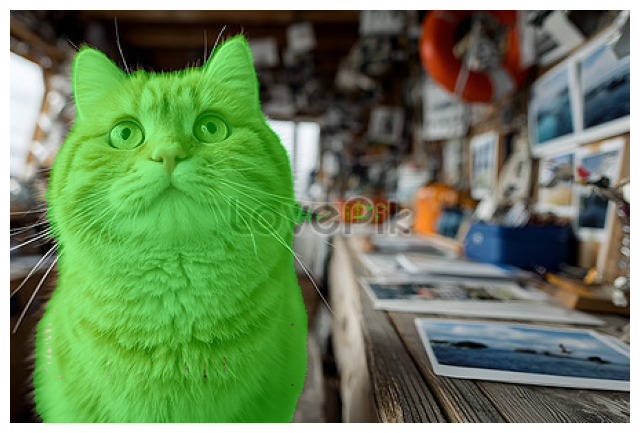

In [63]:
with torch.no_grad():
    outputs = model(**inputs)

masks = processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"], mask_threshold=-2)[0]

print(f"Generated {masks.shape[1]} masks with shape {masks.shape}")
overlay = overlay_mask_translucent(img, masks[0, 0])
plt.figure(figsize=(8,8)); plt.imshow(overlay); plt.axis('off')